In [44]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
#data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


> We extract more information from our data with Feature Engineering

In [45]:
# View head of 'Name' column
# .tail() method, which helps you to see the last five rows of your data:
data.Name.tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

> Notive that this columns contains strings (text) that contain 'Title' such as 'Mr', 'Master' and 'Dona'.

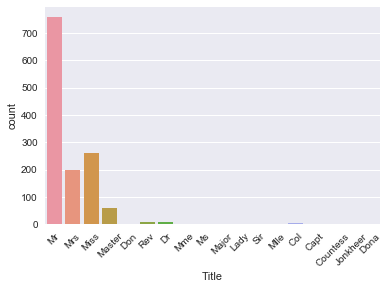

In [46]:
# Extract Title from Name, store in column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

* There are several titles and it makes sense to put them in fewer buckets:
> We extract titles from the neame column

### We add a new feature-  'Title'

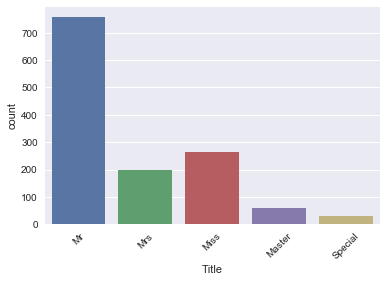

In [47]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

* Check out your data again and make sure that we have a 'Title' column:

In [48]:
# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### We add a new feature 'Has_Cabin': 

* There are several NaNs (missing values) in the 'Cabin' column. It is reasonable to presume that those NaNs didn't have a cabin, which may tell us something about 'Survival'.

In [49]:
# Did they have a Cabin?
'''you want to return True if the passenger has a cabin, bcos isnull returns true if passenger doesn't have a cabin. 
That's why you use the tilde ~
'''
data['Has_Cabin'] = ~data.Cabin.isnull()

# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Has_Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


> * We drop  `['Cabin', 'Name', 'PassengerId', 'Ticket']`:
> * We drop the 'PassengerId' and the 'Ticket' columns because these will probably not tell you anything more about the survival of the Titanic passengers and we already extracted title from the name column

In [50]:
# Drop columns and view head
#inplace drops it in the actual dataframe
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


### Dealing with missing values

* Figure out if there are any missing values left:

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1046 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1308 non-null float64
Embarked     1307 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


* Impute missing values:

In [52]:
# Impute missing values for Age, Fare, Embarked
data.Age = data.Age.fillna(data.Age.median())
data.Fare = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1309 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1309 non-null float64
Embarked     1309 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [53]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


### Bin numerical data

* Use the `pandas` function `qcut` to bin your numerical data:
* **You want to bin the numerical data, because you have a range of ages and fares. However, there might be fluctuations in those numbers that don't reflect patterns in the data, which might be noise. That's why you'll put people that are within a certain range of age or fare in the same bin. You can do this by using the pandas function qcut() to bin your numerical data**

In [54]:
# Binning numerical columns
# set the labels argument to False to encode the bins as numbers. 
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False)
data['CatFare']= pd.qcut(data.Age, q=4, labels=False)
data.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,22.0,1,0,7.2500,S,Mr,False,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,True,3,3
2,3,female,26.0,0,0,7.9250,S,Miss,False,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,True,2,2
4,3,male,35.0,0,0,8.0500,S,Mr,False,2,2


In [55]:
?pd.qcut

* You can now safely drop 'Age' and 'Fare' columns:

In [56]:
data = data.drop(['Age', 'Fare'], axis=1)
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,1,0,S,Mr,False,0,0
1,1,female,1,0,C,Mrs,True,3,3
2,3,female,0,0,S,Miss,False,1,1
3,1,female,1,0,S,Mrs,True,2,2
4,3,male,0,0,S,Mr,False,2,2


## Create a new column: number of members in family onboard

In [57]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.Parch + data.SibSp

In [58]:
# Drop columns
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,Pclass,Sex,Embarked,Title,Has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,2,1
4,3,male,S,Mr,False,2,2,0


## Transform all variables into numerical variables

In [59]:
# Transform into binary variables
#That is transform all variables into numeric ones.
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,Pclass,Has_Cabin,CatAge,CatFare,Fam_Size,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,2,1,0,0,1,0,0,1,0
4,3,False,2,2,0,1,0,1,0,1,0,0


## Building models with our new dataset!

* As before, first you'll split your `data` back into training and test sets; then you'll transform them into arrays:

> To choose your hyperparameter `max_depth`, we  use a variation on test train split called cross validation.


In [60]:
# Split into test.train
data_train = data_dum.iloc[:891]
data_test = data_dum.iloc[891:]

# Transform into arrays for scikit-learn
X = data_train.values
test = data_test.values
y = survived_train.values

In [61]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid = {'max_depth': dep}

# Instantiate a decisionTree Classifier : clf
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))


Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8294051627384961


* Make predictions on your test set, create a new column 'Survived' and store your predictions in it. Save 'PassengerId' and 'Survived' columns of `df_test` to a .csv and submit to Kaggle.

In [62]:
Y_pred = clf_cv.predict(test)
df_test['Survived'] = Y_pred
df_test[['PassengerId', 'Survived']].to_csv('data/predictions/dec_tree_feat_eng.csv', index=False)

* What was the accuracy?

_Accuracy_ = ??

## Next steps

See if you can do some more feature engineering and try some new models out to improve on this score. I'll post all of this on github and on the DataCamp community and it would be great to see all of you improve on these models.

There's a lot more pre-processing that you'd like to learn about, such as scaling your data. You'll also find scikit-learn pipelines super useful. Check out our [Supervised Learning with scikit-learn course](https://www.datacamp.com/courses/supervised-learning-with-scikit-learn) and the [scikit-learn docs](http://scikit-learn.org/stable/) for all of this and more.